In [1]:
#! pip install seaborn

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from scipy.stats import randint
from scipy.stats import powerlaw

import string

import os

In [3]:
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")

Numpy version: 2.2.0
Pandas version: 2.2.3
Matplotlib version: 3.10.0


In [4]:
# Default plot styling
plt.rcParams.update({
    'figure.figsize': (12, 8),  # default figure size
    'figure.subplot.hspace': 0.5,
    'figure.subplot.wspace': 0.5,

    'axes.grid': False,
    'axes.grid.axis': 'both',
    'axes.grid.which': 'both',
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.labelpad': 20,
    'axes.labelsize': 12,
    'axes.labelweight': 'bold',
    'axes.titlepad': 20,
    'axes.titlesize': 12,
    'axes.titleweight': 'bold',

    'grid.alpha': 0.4,
    'grid.color': '#eeeeee',
    'grid.linestyle': 'dashed',

    'lines.linestyle': 'dashed',
    'lines.color': '#eeeeee66',

    'xtick.top': False,
    'xtick.bottom': False,
    'xtick.labelbottom': True,
    'ytick.right': False,
    'ytick.left': False,
    'ytick.labelleft': True,
})

In [5]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)
    
# this is purely used for model evaluation. Ignoring until submission
train_df = pd.read_csv("./data/train.csv")
evaluation_df = pd.read_csv("./data/test.csv")
df_all = concat_df(train_df, evaluation_df)

train_df.name = 'Training Set'
evaluation_df.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [train_df, evaluation_df]

In [6]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
#test_df.head(5)

# Features

**index**
1. `PassengerId`

**Demographic**
1. `Name` (object - string)
2. `Sex` (categorical - string)
3. `Age` (numeric - float)
4. `SibSp` (numeric - int)
5. `Parch` (numeric - int)

**Fare**
1. `Pclass` (categorical - int)
2. `Cabin` (object - string)
3. `Ticket` (object – string)
4. `Fare` (numeric - float)
5. `Embarked` (categorical)

_likely useful features: person demographics/class, cabin/fare, situational (embarked)_

**Target**
1. `Survived` (bool)

# Problem Definition
_Predict whether a person survived the titanic disaster (boolean classification)._
_We can assume a base model of 50% accuracy with random guessing._
_A slightly more nuanced base model would be to only predict women survive, as that was a general pattern. That assumption would yeild a **base accuracy of 78.8%**._

## Base Heuristic Model

In [8]:
def female_survivors(df):
    num_male = sum(df["Sex"] == "male")
    num_female = sum(df["Sex"] == "female")
    print(f'# males = {num_male}')
    print(f'# females = {num_female}')
    ratio_female = num_female / (num_female + num_male)
    
    female_survivors = df.loc[df.Sex == 'female']["Survived"]
    rate_female = sum(female_survivors)/len(female_survivors)
    print(f"% of women who survived: {rate_female:.2f}")
    
    male_survivors = df.loc[df.Sex == 'male']["Survived"]
    rate_male = sum(male_survivors)/len(male_survivors)
    print(f"% of men who survived: {rate_male:.2f}")
    
    # correct when female survivors or male non-survivors
    correct_guess = rate_female * ratio_female + (1 - rate_male) * (1 - ratio_female)
    #print(f"\n'Base Model' Accuracy: {correct_guess: .1%}")
    return correct_guess

print(f"\n'Base Model' Accuracy: {female_survivors(train_df): .1%}")

# males = 577
# females = 314
% of women who survived: 0.74
% of men who survived: 0.19

'Base Model' Accuracy:  78.7%


# Data Exploration

## Target variable

In [9]:
survived = train_df.Survived
print(f"% Survivors: {sum(survived) / len(survived):.1%}")

% Survivors: 38.4%


([<matplotlib.axis.XTick at 0x11e63e660>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

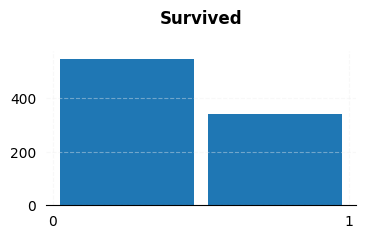

In [10]:
train_df.hist(column='Survived', bins=2, figsize=(4,2), rwidth=0.9)
plt.xticks([0, 1])

## Feature Analysis

### Numerical Features

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Note:
* missing values for Age; will need to impute (strategy: median). Risk: missing values are related to a specific cluster of passengers that is far from median age.
* 2 missing values for embarked; impute with most common value. Low risk given it's only 2 examples.
* Roughly 3/4 have missing cabin values. Leave blank. Too many to impute

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

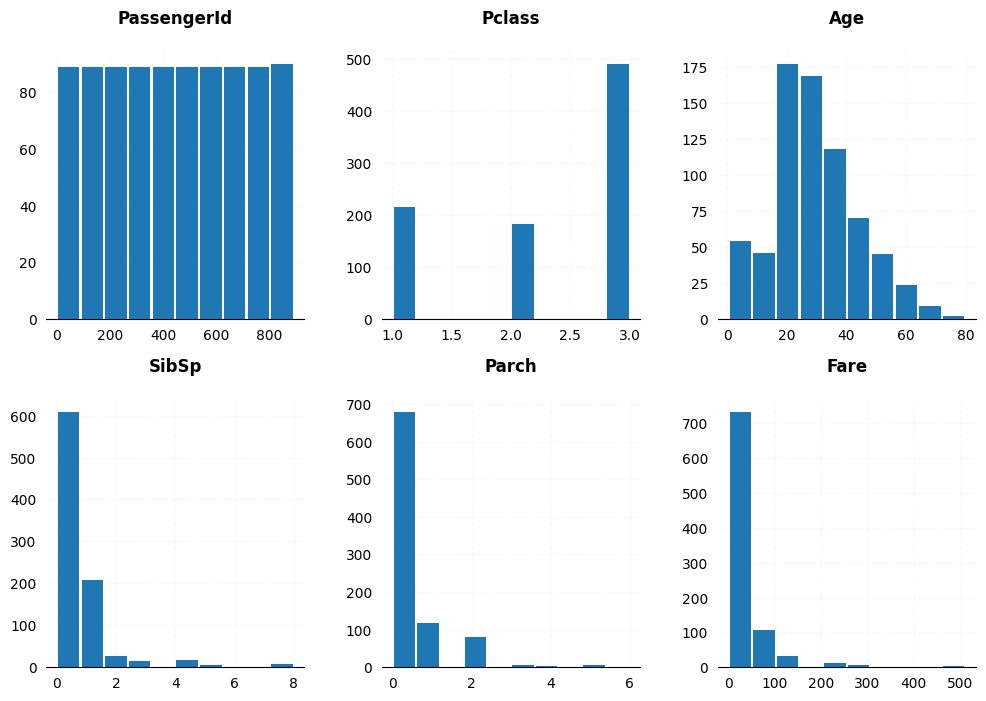

In [13]:
train_df.hist(column=['PassengerId','Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], layout=(2,3), rwidth=0.9, zorder=2)

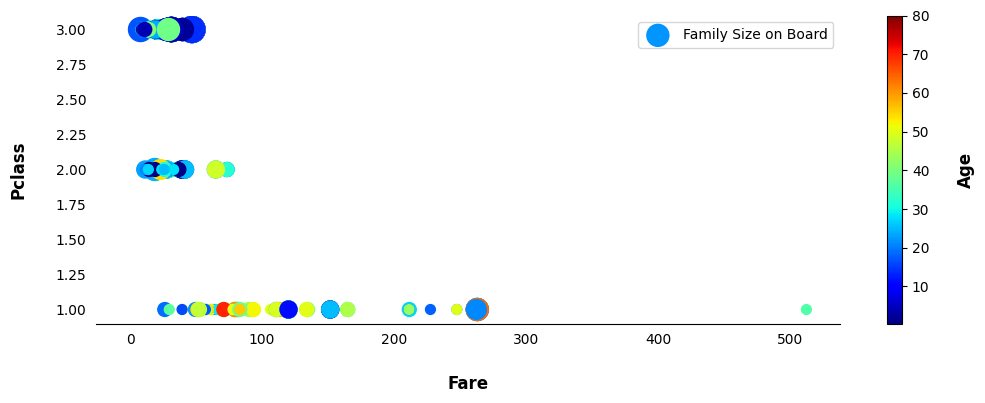

In [14]:
# Analyze if there's a correlation between ticket class and fare
train_df.plot(kind="scatter", y="Pclass", x="Fare",
 s=50*(train_df["Parch"] + train_df["SibSp"]), label="Family Size on Board",
 c="Age", cmap="jet", colorbar=True,
 legend=True, sharex=False, figsize=(12, 4))
plt.show()

#### Thoughts:
* One-hot encode `Pclass`, `Parch`, `Sibsp`
* `Age` looks ok (roughly normal distribution)
* `Fare` can be "power-scaled" (log or sqrt) to transform into normal distribution
* `Pclass` is inverse corrlated with `Fare`

### Object features (strings)

In [15]:
# columns: Sex, Embarked, Cabin, Ticket
print(train_df["Sex"].value_counts())

Sex
male      577
female    314
Name: count, dtype: int64


In [16]:
print(train_df["Embarked"].value_counts())

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


In [17]:
print(train_df["Ticket"].value_counts())

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64


In [18]:
print(train_df["Cabin"].value_counts())

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64


#### Analysis:
* `Sex` and `Embarked` can be one-hot encoded. Impute Embarked with most common value
* `Ticket`: Split into numerical and categorical component (potentially one-hot encode the latter)
* `Cabin`: Split into numerical and categorical component (potentially one-hot encode the latter)

# Data Preparation

Strategy:
* Impute numericals with median
* Impute strings with most common value
* One-hot encode categorical variables

* `Name`: Tokenize (strip by space and punctuation)
* `Pclass`, `Parch`, `Sibsp`, `Sex`, `Cabin`, `Embarked`: One-hot encode
* `Fare`: leave as is
* `Cabin`: One-hot encode the section, potentially one-hot encode group of rows

Drop rows: Cabin, Ticket, Name

## Data Cleaning

In [19]:
# Drop columns: Cabin, Ticket, Name; Survivor moved to titanic_labels
titanic_data = train_df.drop(["Survived", "Name", "Cabin", "Ticket"], axis=1)
titanic_labels = train_df["Survived"].copy()
print(titanic_data.shape, titanic_labels.shape)

(891, 8) (891,)


In [20]:
# Impute median for all numeric values (needed for Age)
imputer = SimpleImputer(strategy="median")
titanic_num = titanic_data.select_dtypes(include=[np.number])
imputer.fit_transform(titanic_num)

print(imputer.statistics_) # Median age = 28
imputer.feature_names_in_

[446.       3.      28.       0.       0.      14.4542]


array(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'],
      dtype=object)

In [21]:
titanic_num.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


In [22]:
# Impute most frequent value for Embarked
imputer_cat = SimpleImputer(strategy="most_frequent")
imputer_cat.fit_transform(titanic_data[["Embarked"]])

print(imputer_cat.statistics_) # Most Frequent value = 'S'
imputer_cat.feature_names_in_

['S']


array(['Embarked'], dtype=object)

In [23]:
cat_encoder = OneHotEncoder()
# titanic_cat = titanic_data.select_dtypes(include=[object])
titanic_cat = titanic_data[['Sex', 'Embarked', 'Pclass']]
#titanic_cat.describe()

titanic_cat_1hot = cat_encoder.fit_transform(titanic_cat)
cat_encoder.get_feature_names_out()

array(['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Embarked_nan', 'Pclass_1', 'Pclass_2', 'Pclass_3'], dtype=object)

In [24]:
'''
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
... columns=cat_encoder.get_feature_names_out(),
... index=df_test_unknown.index)
'''

'\ndf_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),\n... columns=cat_encoder.get_feature_names_out(),\n... index=df_test_unknown.index)\n'

In [25]:
fare = pd.qcut(titanic_data['Fare'], 13)
age = pd.qcut(titanic_data['Age'], 10)
temp = train_df.copy()
temp["Fare"] = pd.qcut(temp['Fare'], 13)
temp["Age"] = pd.qcut(temp['Age'], 10)

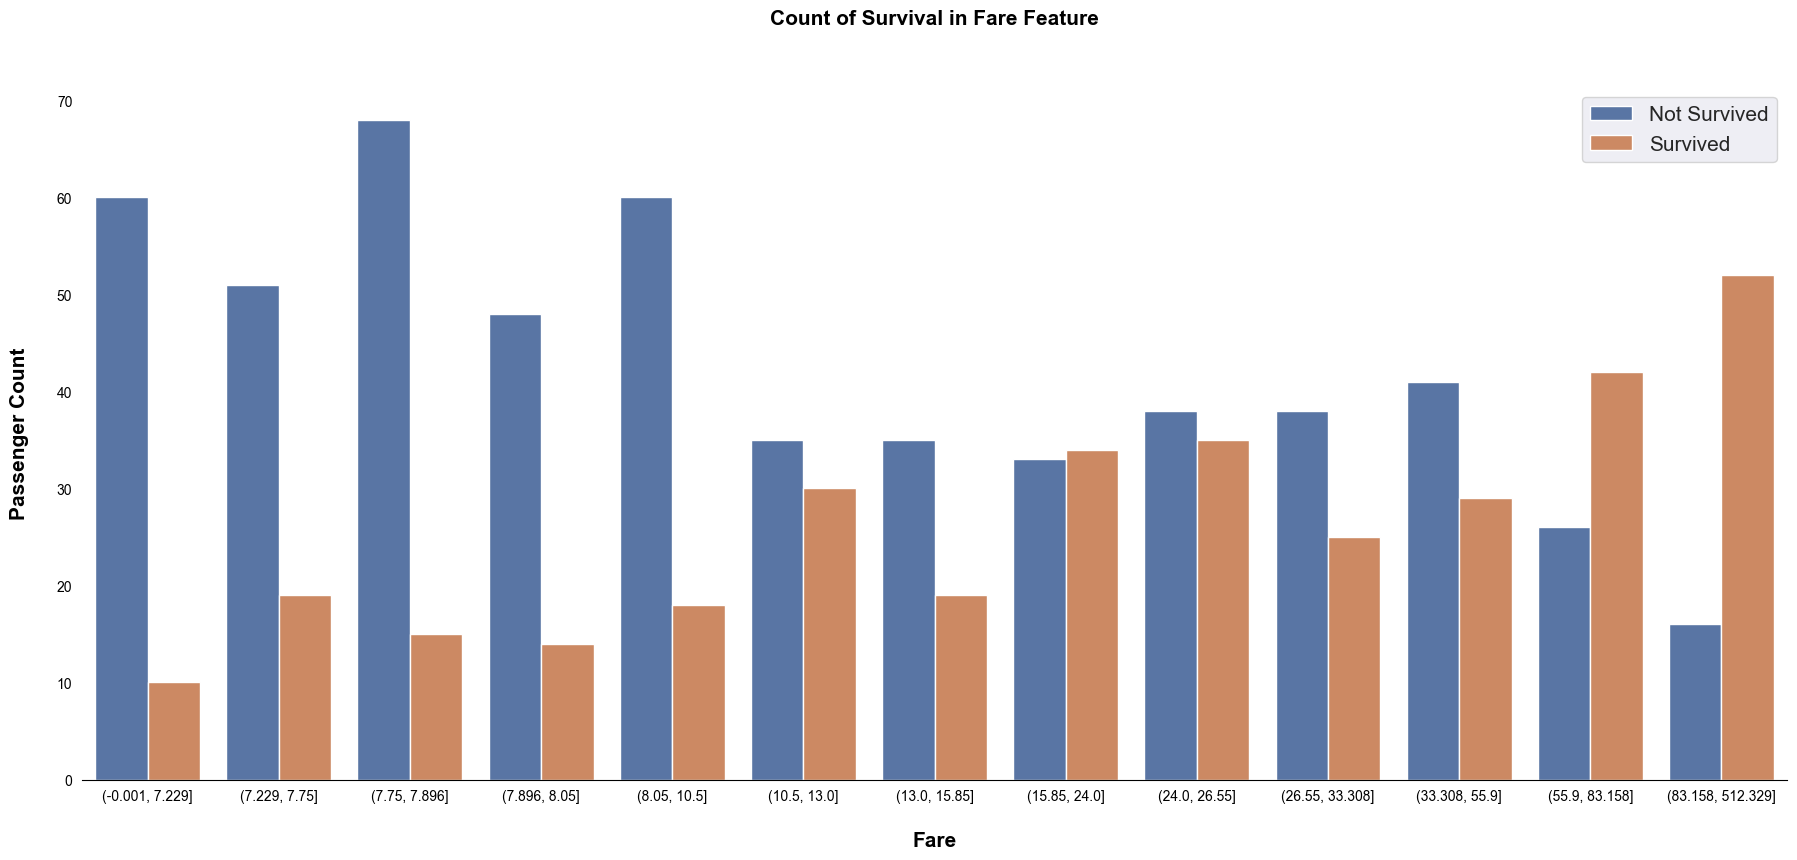

In [26]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.set(style="darkgrid")
sns.countplot(x='Fare', hue='Survived', data=temp)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

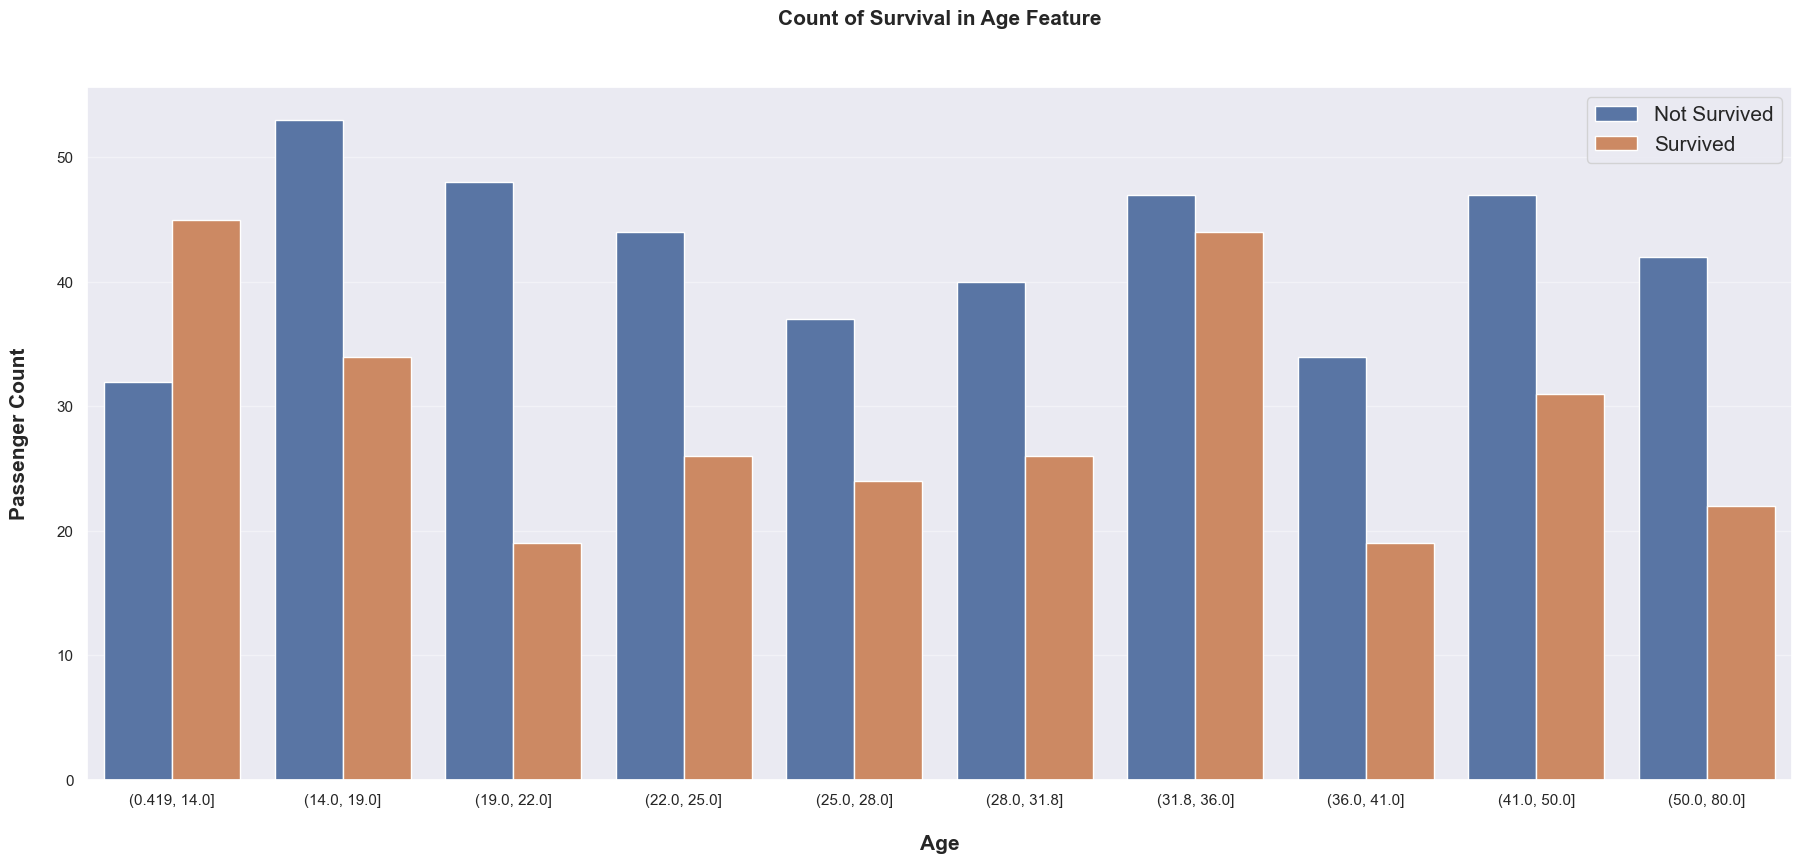

In [27]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.set(style="darkgrid")
sns.countplot(x='Age', hue='Survived', data=temp)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

In [28]:
ordinal_encoder = OrdinalEncoder()
fare_ordinal = ordinal_encoder.fit_transform(pd.DataFrame(fare))
age_ordinal = ordinal_encoder.fit_transform(pd.DataFrame(age))

ordinal_encoder.get_feature_names_out()

array(['Age'], dtype=object)

### Family Size

In [29]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

In [30]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

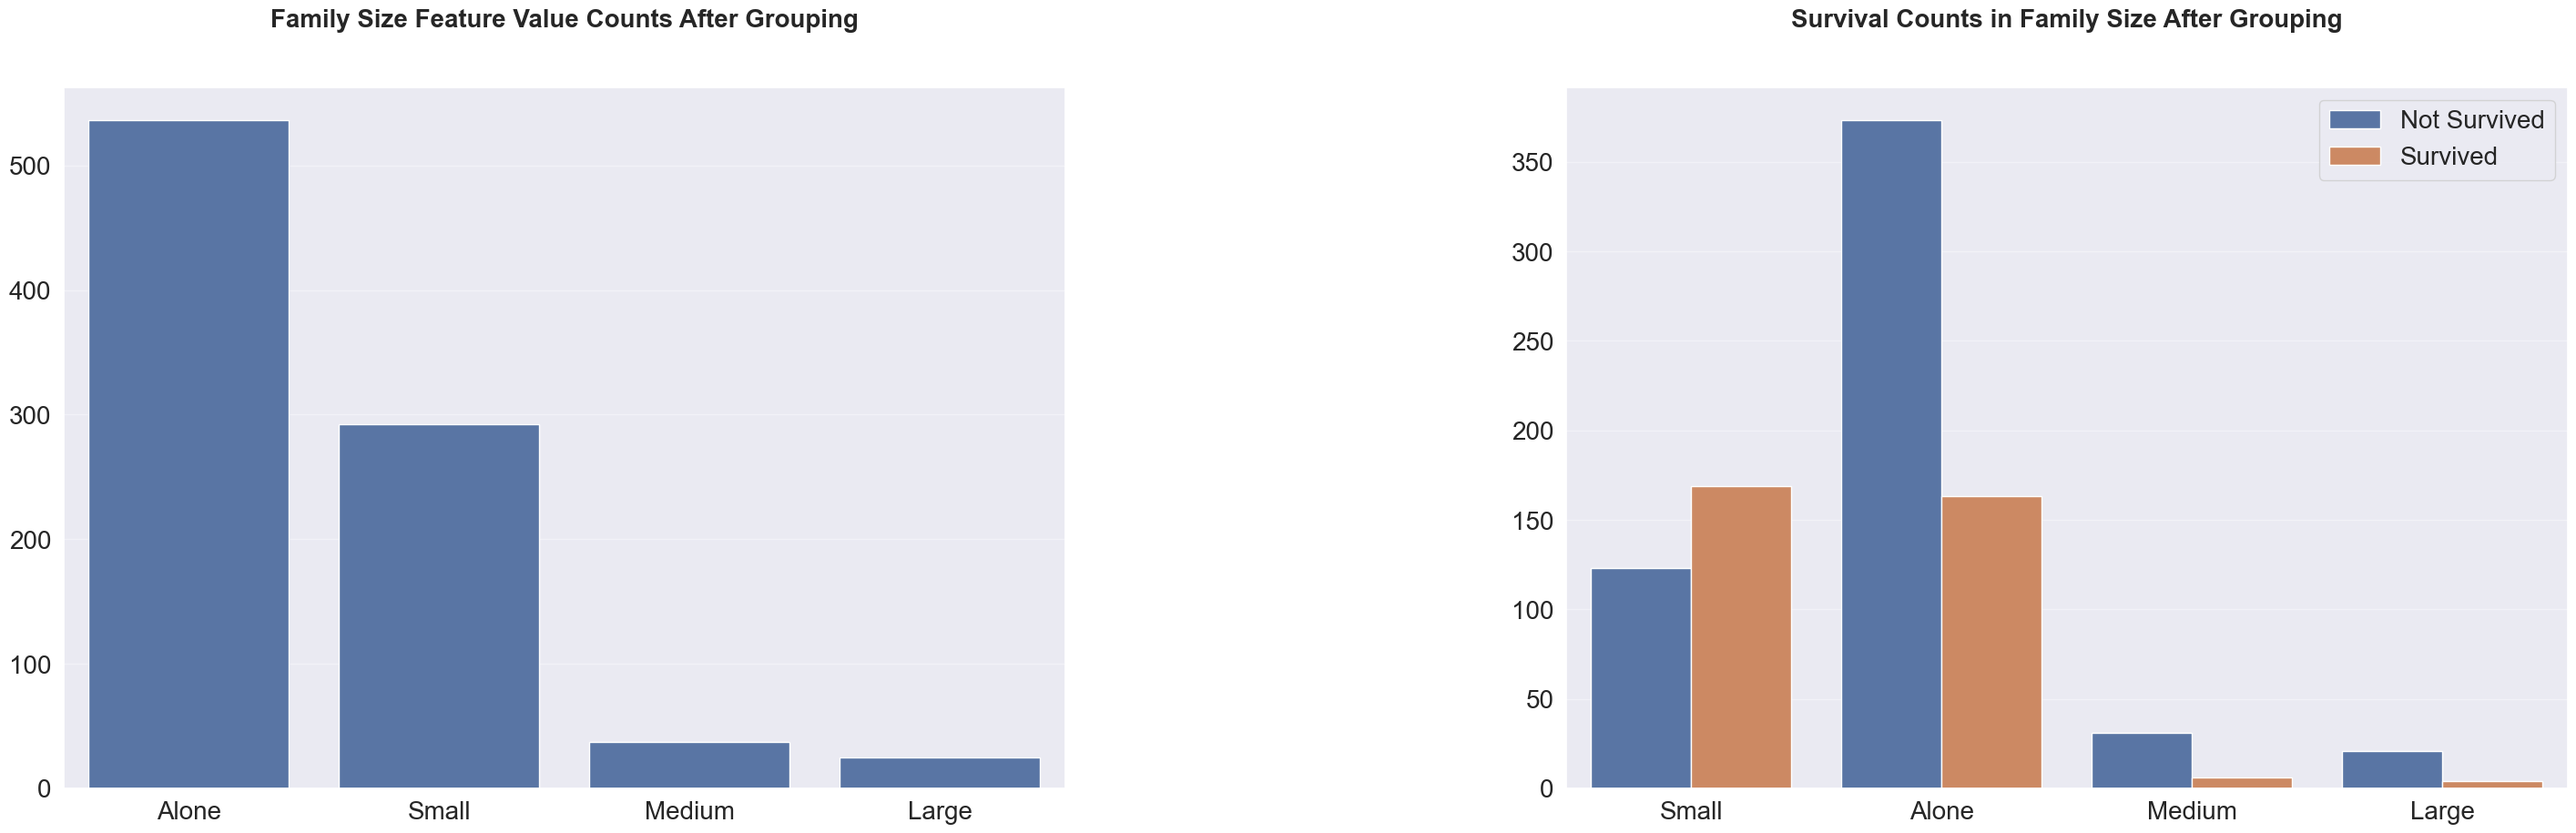

In [31]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=2, nrows=1)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all[:890]['Family_Size_Grouped'].value_counts().index, y=df_all[:890]['Family_Size_Grouped'].value_counts().values, ax=axs[0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all[:890], ax=axs[1])

axs[0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

axs[1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
for j in range(2):
    axs[j].tick_params(axis='x', labelsize=20)
    axs[j].tick_params(axis='y', labelsize=20)
    axs[j].set_xlabel('')
    axs[j].set_ylabel('')

plt.show()

### Title & Is Married?

In [32]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

/var/folders/db/_76p5qt17bv4c9zl791fx9640000gn/T/ipykernel_86395/2015162825.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1
/var/folders/db/_76p5qt17bv4c9zl791fx9640000gn/T/ipykernel

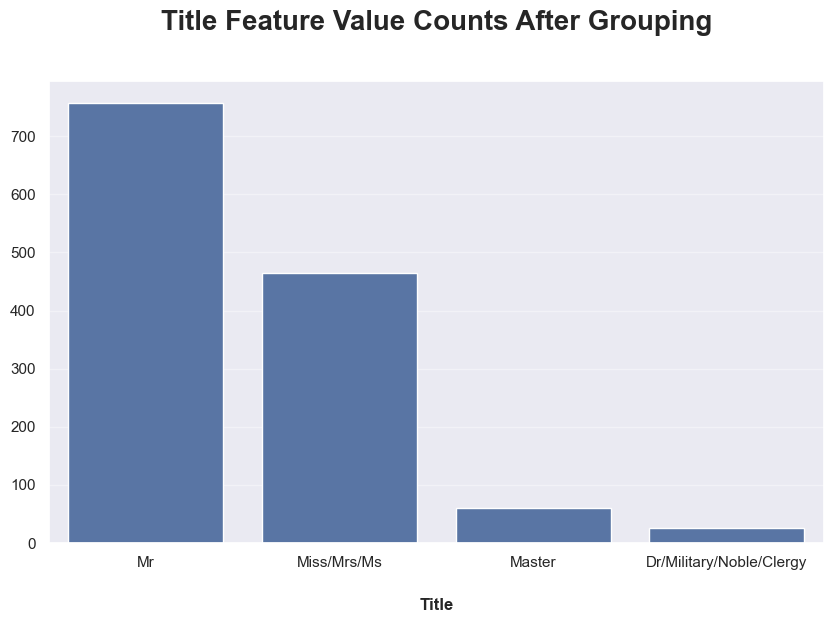

In [33]:
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

fig, axs = plt.subplots(figsize=(10, 6))

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs)
axs.set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

### Surname Feature

In [34]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])

In [35]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature Scaling

In [36]:
#titanic_num["Fare"].hist(figsize=(4,2))

In [37]:
'''fare_log = titanic_num["Fare"]
fare_log = np.where(fare_log == 0, 1, fare_log) 
fare_log = pd.DataFrame(np.log(fare_log), columns=["Fare"])

fare_log.hist(figsize=(4,2))'''

'fare_log = titanic_num["Fare"]\nfare_log = np.where(fare_log == 0, 1, fare_log) \nfare_log = pd.DataFrame(np.log(fare_log), columns=["Fare"])\n\nfare_log.hist(figsize=(4,2))'

In [38]:
'''titanic_num_adj = titanic_num[["PassengerId", "Age", "SibSp", "Parch", "Fare"]]
titanic_num_adj["Fare"] = fare_log # Update fare with log_adjusted value

std_scaler = StandardScaler()
min_max_scalar = MinMaxScaler()
titanic_num_std_scaled = std_scaler.fit_transform(titanic_num_adj[["Age", "Fare"]])
titanic_num_minmax_scaled = min_max_scalar.fit_transform(titanic_num_adj[["PassengerId", "SibSp", "Parch"]])'''

'titanic_num_adj = titanic_num[["PassengerId", "Age", "SibSp", "Parch", "Fare"]]\ntitanic_num_adj["Fare"] = fare_log # Update fare with log_adjusted value\n\nstd_scaler = StandardScaler()\nmin_max_scalar = MinMaxScaler()\ntitanic_num_std_scaled = std_scaler.fit_transform(titanic_num_adj[["Age", "Fare"]])\ntitanic_num_minmax_scaled = min_max_scalar.fit_transform(titanic_num_adj[["PassengerId", "SibSp", "Parch"]])'

In [39]:
'''print(titanic_num_std_scaled.shape)
print(titanic_num_minmax_scaled.shape)
print(titanic_cat_1hot.shape)

print(type(titanic_num_std_scaled))
print(type(titanic_num_minmax_scaled))
print(type(titanic_cat_1hot))'''

'print(titanic_num_std_scaled.shape)\nprint(titanic_num_minmax_scaled.shape)\nprint(titanic_cat_1hot.shape)\n\nprint(type(titanic_num_std_scaled))\nprint(type(titanic_num_minmax_scaled))\nprint(type(titanic_cat_1hot))'

## Transformation Pipeline

In [40]:
num_std_attribs = ["Age", "Fare"]
num_minmax_attribs = ["SibSp", "Parch"]
cat_int_attribs = ["Pclass", "Is_Married"]
cat_attribs = ["Title", "Sex", "Embarked", "Family_Size_Grouped"]

'''
num_std_attribs = ["Age"]
log_attribs = ["Fare"]
num_minmax_attribs = ["PassengerId", "SibSp", "Parch"]
cat_int_attribs = ["Pclass"]
cat_attribs = ["Sex", "Embarked"]
'''

'\nnum_std_attribs = ["Age"]\nlog_attribs = ["Fare"]\nnum_minmax_attribs = ["PassengerId", "SibSp", "Parch"]\ncat_int_attribs = ["Pclass"]\ncat_attribs = ["Sex", "Embarked"]\n'

In [41]:
# For Age
# For Fare
def cut_bins(X):
    cut_bins = pd.cut(X.squeeze(), 10)
    data_frame = pd.DataFrame(cut_bins)
    return data_frame

def interval_pipeline(n_bins):
    return make_pipeline(
        SimpleImputer(strategy="median"),
        KBinsDiscretizer(n_bins=n_bins, encode='ordinal'),
        OrdinalEncoder())

'''
num_std_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(lambda x: x + 1, feature_names_out="one-to-one"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())'''

# For PassengerId, SibSp, Parch
num_minmax_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler())

# For Pclass
cat_int_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    OneHotEncoder(handle_unknown="ignore"))

# For Sex, Embarked
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

ord_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder())

preprocessing = ColumnTransformer([
    ("age_bin", interval_pipeline(8), ["Age"]),
    ("fare_bin", interval_pipeline(13), ["Fare"]),
#    ("log", log_pipeline, log_attribs),
    ("num_minmax", num_minmax_pipeline, num_minmax_attribs),
    ("cat_int", cat_int_pipeline, cat_int_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [42]:
# Drop columns: Cabin, Ticket, Name; Survivor moved to titanic_labels
train_df = df_all[:891]
evaluation_df = df_all[891:]
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

titanic_data = train_df.drop(["Survived", "Name", "Cabin", "Ticket", "Family_Size", "PassengerId"], axis=1)
titanic_labels = train_df["Survived"].copy()
print(titanic_data.shape, titanic_labels.shape)

(712, 11) (712,)


In [43]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  572 non-null    float64
 1   Embarked             710 non-null    object 
 2   Fare                 712 non-null    float64
 3   Parch                712 non-null    int64  
 4   Pclass               712 non-null    int64  
 5   Sex                  712 non-null    object 
 6   SibSp                712 non-null    int64  
 7   Family_Size_Grouped  712 non-null    object 
 8   Title                712 non-null    object 
 9   Is_Married           712 non-null    int64  
 10  Family               712 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


In [44]:
titanic_prepared = preprocessing.fit_transform(titanic_data)
titanic_prepared_df = pd.DataFrame(
    titanic_prepared, columns=preprocessing.get_feature_names_out(),
    index=titanic_data.index)

In [45]:
titanic_prepared_df.describe()

,age_bin__Age,fare_bin__Fare,num_minmax__SibSp,num_minmax__Parch,cat_int__Pclass_1.0,cat_int__Pclass_2.0,cat_int__Pclass_3.0,cat_int__Is_Married_0.0,cat_int__Is_Married_1.0,cat__Title_Dr/Military/Noble/Clergy,...,cat__Title_Mr,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,cat__Family_Size_Grouped_Alone,cat__Family_Size_Grouped_Large,cat__Family_Size_Grouped_Medium,cat__Family_Size_Grouped_Small
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,...,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,3.692416,6.153090,0.069171,0.063202,0.228933,0.212079,0.558989,0.865169,0.134831,0.021067,...,0.588483,0.344101,0.655899,0.175562,0.084270,0.740169,0.602528,0.032303,0.039326,0.325843
std,2.261286,3.628748,0.147051,0.131945,0.420441,0.409068,0.496857,0.341784,0.341784,0.143710,...,0.492454,0.475408,0.475408,0.380714,0.277987,0.438850,0.489719,0.176929,0.194506,0.469018
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,6.000000,9.000000,0.125000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,7.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Correlation Analysis

In [46]:
corr_matrix = train_df[["PassengerId", "Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]].corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.246641
Parch          0.078311
PassengerId    0.019979
SibSp         -0.047602
Age           -0.059695
Pclass        -0.321750
Name: Survived, dtype: float64

In [47]:
# See if total family on board could be useful; looks to be uncorrelated
temp_df = train_df[["PassengerId", "Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]]
temp_df["Family_on_Board"] = temp_df["Parch"] + temp_df["SibSp"]
temp_corr_matrix = temp_df.corr()
temp_corr_matrix["Survived"].sort_values(ascending=False)

/var/folders/db/_76p5qt17bv4c9zl791fx9640000gn/T/ipykernel_86395/1642906041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["Family_on_Board"] = temp_df["Parch"] + temp_df["SibSp"]


Survived           1.000000
Fare               0.246641
Parch              0.078311
PassengerId        0.019979
Family_on_Board    0.003565
SibSp             -0.047602
Age               -0.059695
Pclass            -0.321750
Name: Survived, dtype: float64

In [48]:
test = titanic_prepared_df
test["Survived"] = titanic_labels
corr_matrix = test.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived                               1.000000
cat__Sex_female                        0.541750
cat__Title_Miss/Mrs/Ms                 0.541750
cat_int__Is_Married_1.0                0.372319
fare_bin__Fare                         0.292575
cat_int__Pclass_1.0                    0.259753
cat__Family_Size_Grouped_Small         0.257765
cat__Embarked_C                        0.159632
cat_int__Pclass_2.0                    0.114623
num_minmax__Parch                      0.078311
cat__Title_Master                      0.076923
cat__Embarked_Q                       -0.006097
age_bin__Age                          -0.027669
cat__Title_Dr/Military/Noble/Clergy   -0.033228
num_minmax__SibSp                     -0.047602
cat__Family_Size_Grouped_Medium       -0.082617
cat__Family_Size_Grouped_Large        -0.092759
cat__Embarked_S                       -0.134623
cat__Family_Size_Grouped_Alone        -0.180542
cat_int__Pclass_3.0                   -0.314174
cat_int__Is_Married_0.0               -0

After feature transformations, the most indicative features are:
* Sex
* Fare
* Pclass
* Embarked

# Model Training

## Logistic Regression

In [49]:
log_reg = make_pipeline(preprocessing, LogisticRegression())
log_reg.fit(titanic_data, titanic_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('age_bin',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=8)),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Age']),
                                                 ('fare_bin',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscr...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Is_Married']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Title', 'Sex', 'Embarked',
                                                   'Family_Size_Grouped'])])),
                ('logisticregression', LogisticRegression())])

In [50]:
titanic_predictions = log_reg.predict(titanic_data)
print(titanic_predictions[:20].round(2))
print(titanic_labels.iloc[:20].values)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.]


In [51]:
log_reg_accuracy = accuracy_score(titanic_predictions, titanic_labels)
print(f"Logistic Regression Accuracy: {log_reg_accuracy:.2%}")

Logistic Regression Accuracy: 83.15%


## Decision Tree

In [52]:
tree_class = make_pipeline(preprocessing, DecisionTreeClassifier(max_depth=5, random_state=42))
tree_class.fit(titanic_data, titanic_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('age_bin',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=8)),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Age']),
                                                 ('fare_bin',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscr...
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Is_Married']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Title', 'Sex', 'Embarked',
                                                   'Family_Size_Grouped'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [53]:
tree_class_pred = tree_class.predict(titanic_data)
print(tree_class_pred[:20].round(2))
print(titanic_labels.iloc[:20].values)
tree_class_accuracy = accuracy_score(tree_class_pred, titanic_labels)
print(f"Decision Tree Accuracy: {tree_class_accuracy:.2%}")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.]
Decision Tree Accuracy: 84.83%


## Random Forest

In [54]:
forest_class = make_pipeline(preprocessing, RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
forest_class.fit(titanic_data, titanic_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('age_bin',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=8)),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Age']),
                                                 ('fare_bin',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscr...
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Is_Married']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Title', 'Sex', 'Embarked',
                                                   'Family_Size_Grouped'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, random_state=42))])

In [55]:
forest_class_pred = forest_class.predict(titanic_data)
print(forest_class_pred[:20].round(2))
print(titanic_labels.iloc[:20].values)
forest_class_accuracy = accuracy_score(forest_class_pred, titanic_labels)
print(f"Random Forest Accuracy: {forest_class_accuracy:.2%}")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.]
Random Forest Accuracy: 84.83%


## GradientBoostingClassifier

In [56]:
boost_class = make_pipeline(preprocessing, GradientBoostingClassifier())
boost_class.fit(titanic_data, titanic_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('age_bin',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=8)),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Age']),
                                                 ('fare_bin',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscr...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Is_Married']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Title', 'Sex', 'Embarked',
                                                   'Family_Size_Grouped'])])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [57]:
boost_class_pred = boost_class.predict(titanic_data)
print(boost_class_pred[:20].round(2))
print(titanic_labels.iloc[:20].values)
boost_class_accuracy = accuracy_score(boost_class_pred, titanic_labels)
print(f"Gradient Boosting Accuracy: {boost_class_accuracy:.2%}")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.]
Gradient Boosting Accuracy: 88.34%


## Cross-Validation

In [58]:
log_reg_accuracies = cross_val_score(log_reg, titanic_data, titanic_labels, 
                                        scoring="accuracy", cv=10)

In [59]:
pd.Series(log_reg_accuracies).describe()

count    10.000000
mean      0.827210
std       0.074574
min       0.732394
25%       0.778169
50%       0.811228
75%       0.867518
max       0.943662
dtype: float64

In [60]:
tree_class_accuracies = cross_val_score(tree_class, titanic_data, titanic_labels, 
                                        scoring="accuracy", cv=10)

In [61]:
pd.Series(tree_class_accuracies).describe()

count    10.000000
mean      0.813204
std       0.060467
min       0.746479
25%       0.774648
50%       0.790200
75%       0.852700
max       0.943662
dtype: float64

In [62]:
forest_class_accuracies = cross_val_score(forest_class, titanic_data, titanic_labels, 
                                        scoring="accuracy", cv=10)

In [63]:
pd.Series(forest_class_accuracies).describe()

count    10.000000
mean      0.832844
std       0.070086
min       0.746479
25%       0.782375
50%       0.823944
75%       0.871039
max       0.957746
dtype: float64

In [64]:
boost_class_accuracies = cross_val_score(boost_class, titanic_data, titanic_labels, 
                                        scoring="accuracy", cv=10)

In [65]:
pd.Series(boost_class_accuracies).describe()

count    10.000000
mean      0.824491
std       0.065252
min       0.760563
25%       0.775430
50%       0.809859
75%       0.852700
max       0.957746
dtype: float64

# Fine Tuning
_**Analysis**: All the models are fairly similar and close to the base heuristic accuracy (79%), but Random Forest and Gradient Boosting are the most promissing to tune_
4 attemps:
* Random Forest (GridSearch)
* Random Forest (RandomizedSearch)
* Gradient Boosting (GridSearch)
* Gradient Boosting (RandomizedSearch)

## Grid Search – Random Forest

In [66]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=42)),
])

param_grid = [
 {'random_forest__max_depth': [3, 5, 10, 20],
 'random_forest__max_features': [4, 6, 8],
 'random_forest__n_estimators': [5, 10, 20]}
]

grid_search_forest = GridSearchCV(full_pipeline, param_grid, cv=10,
                           scoring='accuracy')

grid_search_forest.fit(titanic_data, titanic_labels)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('age_bin',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('kbinsdiscretizer',
                                                                                          KBinsDiscretizer(encode='ordinal',
                                                                                                           n_bins=8)),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['Age']),
                                                                        ('fare_bin',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strateg...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Title',
                                                                          'Sex',
                                                                          'Embarked',
                                                                          'Family_Size_Grouped'])])),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid=[{'random_forest__max_depth': [3, 5, 10, 20],
                          'random_forest__max_features': [4, 6, 8],
                          'random_forest__n_estimators': [5, 10, 20]}],
             scoring='accuracy')

In [67]:
grid_search_forest.best_params_

{'random_forest__max_depth': 5,
 'random_forest__max_features': 4,
 'random_forest__n_estimators': 10}

In [68]:
cv_res = pd.DataFrame(grid_search_forest.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__max_features,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
10,0.014719,0.000047,0.004486,0.000102,5,4,10,"{'random_forest__max_depth': 5, 'random_forest...",0.847222,0.805556,...,0.971831,0.873239,0.760563,0.816901,0.816901,0.774648,0.929577,0.834292,0.069149,1
11,0.020659,0.000052,0.004756,0.000140,5,4,20,"{'random_forest__max_depth': 5, 'random_forest...",0.861111,0.805556,...,0.971831,0.859155,0.760563,0.816901,0.788732,0.774648,0.915493,0.831455,0.066634,2
16,0.015083,0.000047,0.004477,0.000098,5,8,10,"{'random_forest__max_depth': 5, 'random_forest...",0.875000,0.819444,...,0.943662,0.873239,0.760563,0.816901,0.774648,0.802817,0.901408,0.831416,0.061462,3
15,0.011991,0.000123,0.004381,0.000098,5,8,5,"{'random_forest__max_depth': 5, 'random_forest...",0.861111,0.791667,...,0.957746,0.859155,0.760563,0.802817,0.802817,0.802817,0.901408,0.830067,0.060469,4
5,0.020509,0.000119,0.004754,0.000103,3,6,20,"{'random_forest__max_depth': 3, 'random_forest...",0.888889,0.805556,...,0.957746,0.859155,0.746479,0.816901,0.802817,0.774648,0.915493,0.830008,0.070015,5


## Randomized Search – Random Forest

In [69]:
param_distribs = {'random_forest__max_depth': randint(low=1, high=10),
                  'random_forest__max_features': randint(low=1, high=10),
                  'random_forest__n_estimators': randint(low=1, high=100)}

rnd_search_forest = RandomizedSearchCV(full_pipeline,
                                param_distributions=param_distribs,
                                n_iter=100, cv=10,
                                scoring='accuracy')

rnd_search_forest.fit(titanic_data, titanic_labels)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('age_bin',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('kbinsdiscretizer',
                                                                                                KBinsDiscretizer(encode='ordinal',
                                                                                                                 n_bins=8)),
                                                                                               ('ordinalencoder',
                                                                                                OrdinalEncoder())]),
                                                                               ['Age']),
                                                                              ('fare_bin',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(s...
                   param_distributions={'random_forest__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11eba4830>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11ee0c190>,
                                        'random_forest__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11ee0ca50>},
                   scoring='accuracy')

In [70]:
rnd_search_forest.best_params_

{'random_forest__max_depth': 6,
 'random_forest__max_features': 2,
 'random_forest__n_estimators': 74}

In [71]:
cv_res_rnd = pd.DataFrame(rnd_search_forest.cv_results_)
cv_res_rnd.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res_rnd.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__max_features,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
78,0.051581,0.000102,0.006082,0.000090,6,2,74,"{'random_forest__max_depth': 6, 'random_forest...",0.888889,0.805556,...,0.957746,0.859155,0.746479,0.830986,0.802817,0.802817,0.929577,0.838459,0.066114,1
12,0.023734,0.000041,0.004913,0.000118,5,2,26,"{'random_forest__max_depth': 5, 'random_forest...",0.888889,0.805556,...,0.957746,0.873239,0.760563,0.816901,0.802817,0.774648,0.929577,0.835642,0.069010,2
49,0.054137,0.000123,0.006166,0.000128,4,4,79,"{'random_forest__max_depth': 4, 'random_forest...",0.888889,0.805556,...,0.971831,0.859155,0.746479,0.816901,0.816901,0.774648,0.915493,0.834233,0.070370,3
52,0.060449,0.000582,0.006525,0.000074,7,1,85,"{'random_forest__max_depth': 7, 'random_forest...",0.847222,0.805556,...,0.957746,0.873239,0.760563,0.830986,0.788732,0.774648,0.929577,0.832883,0.065823,4
11,0.059879,0.001193,0.006530,0.000177,7,1,87,"{'random_forest__max_depth': 7, 'random_forest...",0.847222,0.805556,...,0.957746,0.873239,0.760563,0.830986,0.788732,0.774648,0.929577,0.832883,0.065823,4


## Grid Search – Gradient Boosting

In [72]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("gradient_boosting", GradientBoostingClassifier(random_state=42)),
])

param_grid = [
 {'gradient_boosting__learning_rate': [0.01],
  'gradient_boosting__max_depth': [3, 5],
  'gradient_boosting__n_estimators': [100, 200, 500],
  'gradient_boosting__min_samples_split': [1, 2],
  'gradient_boosting__min_samples_leaf': [1, 2],
 }
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=10,
                           scoring='accuracy')

grid_search.fit(titanic_data, titanic_labels)

/Users/Shronas/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Shronas/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/Shronas/venv/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/Shronas/venv/lib/python3.13/site-packages/sklearn/pipeline.py", line 660, in fit
  

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('age_bin',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('kbinsdiscretizer',
                                                                                          KBinsDiscretizer(encode='ordinal',
                                                                                                           n_bins=8)),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['Age']),
                                                                        ('fare_bin',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strateg...
                                                                          'Embarked',
                                                                          'Family_Size_Grouped'])])),
                                       ('gradient_boosting',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid=[{'gradient_boosting__learning_rate': [0.01],
                          'gradient_boosting__max_depth': [3, 5],
                          'gradient_boosting__min_samples_leaf': [1, 2],
                          'gradient_boosting__min_samples_split': [1, 2],
                          'gradient_boosting__n_estimators': [100, 200, 500]}],
             scoring='accuracy')

In [73]:
grid_search.best_params_

{'gradient_boosting__learning_rate': 0.01,
 'gradient_boosting__max_depth': 3,
 'gradient_boosting__min_samples_leaf': 1,
 'gradient_boosting__min_samples_split': 2,
 'gradient_boosting__n_estimators': 100}

In [74]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradient_boosting__learning_rate,param_gradient_boosting__max_depth,param_gradient_boosting__min_samples_leaf,param_gradient_boosting__min_samples_split,param_gradient_boosting__n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,0.065128,0.000421,0.004561,0.000193,0.01,3,1,2,100,"{'gradient_boosting__learning_rate': 0.01, 'gr...",...,0.971831,0.901408,0.774648,0.816901,0.774648,0.774648,0.901408,0.834253,0.071701,1
9,0.064698,0.000135,0.004467,0.000119,0.01,3,2,2,100,"{'gradient_boosting__learning_rate': 0.01, 'gr...",...,0.971831,0.901408,0.774648,0.816901,0.774648,0.774648,0.901408,0.834253,0.071701,1
4,0.120399,0.000168,0.004544,0.000103,0.01,3,1,2,200,"{'gradient_boosting__learning_rate': 0.01, 'gr...",...,0.971831,0.901408,0.774648,0.802817,0.774648,0.774648,0.901408,0.831455,0.069832,3
10,0.120202,0.000348,0.004533,0.000118,0.01,3,2,2,200,"{'gradient_boosting__learning_rate': 0.01, 'gr...",...,0.971831,0.901408,0.774648,0.802817,0.774648,0.774648,0.901408,0.831455,0.069832,3
23,0.506450,0.008046,0.005044,0.000153,0.01,5,2,2,500,"{'gradient_boosting__learning_rate': 0.01, 'gr...",...,0.929577,0.859155,0.760563,0.830986,0.802817,0.816901,0.873239,0.825880,0.048712,5


## Random Search – Boosting

In [75]:
param_distribs = {'gradient_boosting__learning_rate': powerlaw(1),
                  'gradient_boosting__max_depth': randint(low=1, high=5),
                  'gradient_boosting__n_estimators': randint(low=50, high=1000),
                  'gradient_boosting__min_samples_split': randint(low=1, high=5),
                  'gradient_boosting__min_samples_leaf': randint(low=1, high=5)
                 }

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("gradient_boosting", GradientBoostingClassifier(random_state=42)),
])

rnd_search = RandomizedSearchCV(full_pipeline,
                                param_distributions=param_distribs,
                                n_iter=10, cv=10,
                                scoring='accuracy', random_state=42)

rnd_search.fit(titanic_data, titanic_labels)

/Users/Shronas/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Shronas/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/Shronas/venv/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/Shronas/venv/lib/python3.13/site-packages/sklearn/pipeline.py", line 660, in fit
    

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('age_bin',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('kbinsdiscretizer',
                                                                                                KBinsDiscretizer(encode='ordinal',
                                                                                                                 n_bins=8)),
                                                                                               ('ordinalencoder',
                                                                                                OrdinalEncoder())]),
                                                                               ['Age']),
                                                                              ('fare_bin',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(s...
                                        'gradient_boosting__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11e8de140>,
                                        'gradient_boosting__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11eeeed50>,
                                        'gradient_boosting__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11e6c6c40>},
                   random_state=42, scoring='accuracy')

In [76]:
rnd_search.best_params_

{'gradient_boosting__learning_rate': np.float64(0.0906064345328208),
 'gradient_boosting__max_depth': 2,
 'gradient_boosting__min_samples_leaf': 3,
 'gradient_boosting__min_samples_split': 4,
 'gradient_boosting__n_estimators': 616}

In [77]:
cv_res_rnd = pd.DataFrame(rnd_search.cv_results_)
cv_res_rnd.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res_rnd.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradient_boosting__learning_rate,param_gradient_boosting__max_depth,param_gradient_boosting__min_samples_leaf,param_gradient_boosting__min_samples_split,param_gradient_boosting__n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
8,0.266341,0.003446,0.004730,0.000109,0.090606,2,3,4,616,{'gradient_boosting__learning_rate': 0.0906064...,...,0.957746,0.845070,0.760563,0.830986,0.830986,0.732394,0.901408,0.824491,0.064416,1
0,0.047008,0.000848,0.004392,0.000218,0.374540,1,3,3,121,{'gradient_boosting__learning_rate': 0.3745401...,...,0.943662,0.830986,0.774648,0.816901,0.774648,0.760563,0.915493,0.821616,0.063293,2
6,0.404263,0.001132,0.004974,0.000059,0.023062,3,3,3,731,{'gradient_boosting__learning_rate': 0.0230624...,...,0.929577,0.859155,0.760563,0.816901,0.774648,0.788732,0.887324,0.820246,0.053283,3
7,0.181397,0.004760,0.004686,0.000162,0.046666,4,4,3,239,{'gradient_boosting__learning_rate': 0.0466656...,...,0.915493,0.859155,0.760563,0.816901,0.816901,0.774648,0.873239,0.818838,0.049695,4
3,0.172528,0.000296,0.004571,0.000090,0.708073,2,1,2,393,{'gradient_boosting__learning_rate': 0.7080725...,...,0.873239,0.788732,0.760563,0.816901,0.774648,0.774648,0.859155,0.799178,0.037669,5


## Best Model

In [78]:
final_model = rnd_search_forest.best_estimator_ # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.05, 0.07, 0.04, 0.03, 0.04, 0.02, 0.05, 0.06, 0.04, 0.  , 0.02,
       0.11, 0.13, 0.12, 0.11, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.03])

In [79]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(np.float64(0.12525888388229153), 'cat__Title_Mr'),
 (np.float64(0.11887225223031551), 'cat__Sex_female'),
 (np.float64(0.1119739924457721), 'cat__Title_Miss/Mrs/Ms'),
 (np.float64(0.10721088215603615), 'cat__Sex_male'),
 (np.float64(0.07452919946201289), 'fare_bin__Fare'),
 (np.float64(0.062610046622362), 'cat_int__Is_Married_0.0'),
 (np.float64(0.05265515575152953), 'cat_int__Pclass_3.0'),
 (np.float64(0.050162520577922094), 'age_bin__Age'),
 (np.float64(0.04344783312282284), 'cat_int__Is_Married_1.0'),
 (np.float64(0.03934351115123591), 'cat_int__Pclass_1.0'),
 (np.float64(0.03524073276239493), 'num_minmax__SibSp'),
 (np.float64(0.02833588619663357), 'cat__Family_Size_Grouped_Small'),
 (np.float64(0.027466199822063997), 'num_minmax__Parch'),
 (np.float64(0.021386247454993634), 'cat__Title_Master'),
 (np.float64(0.019803774407401605), 'cat_int__Pclass_2.0'),
 (np.float64(0.01642064708525152), 'cat__Family_Size_Grouped_Alone'),
 (np.float64(0.014842052172809523), 'cat__Embarked_C'),


In [80]:
X_test = test_df.drop("Survived", axis=1)
y_test = test_df["Survived"].copy()

final_predictions = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_predictions)
print(f"Final Model Accuracy: {final_accuracy:.2%}")

Final Model Accuracy: 82.12%


In [81]:
print(f"\n'Base Model' Accuracy: {female_survivors(test_df): .1%}")

# males = 110
# females = 69
% of women who survived: 0.75
% of men who survived: 0.20

'Base Model' Accuracy:  78.2%


# Kaggle Competition Export

In [82]:
kaggle_final = rnd_search_forest.best_estimator_
eval_predications = kaggle_final.predict(evaluation_df)

submission = pd.DataFrame({'PassengerId': evaluation_df.PassengerId,
                                'Survived': eval_predications.astype(int)})
submission.to_csv('submission.csv', index=False)